## NWM Retrospective Streamflow Visualization

This example demonstrates how to collect and visualize NWM retrospective predictions using Python

NWM Retrospective data is located at:

https://registry.opendata.aws/nwm-archive/




**Requirements**

This notebook was developed using the following software and operating system versions.

OS: MacOS Ventura 13.0.1  
Python: 3.10.0
Zarr: 2.13.2  
NetCDF4: 1.6.1  
xarray: 0.17.0  
fsspec: 0.8.7  
dask: 2021.3.0  
hvplot: 0.7.1  
holoviews: 1.14.2  
pynhd: 0.10.1
nest-asyncio: 1.5.6


The following commands should help you set up these dependencies
```
$ conda create -n nwm-env python=3.10.0

$ conda install -y -c pyviz -c conda-forge pynhd folium s3fs hvplot dask distributed zarr

```

In [ ]:
import os
import pandas
import xarray
import s3fs
import hvplot.xarray

from dask.distributed import Client
client = Client()
client

## Cubic feet to cubic meters conversion factor
cfs_2_cms = 0.0283168466

## Create Map for Watershed for USGS Station ID

The following code uses `pynhd` and `folium` to create an interactive map of a watershed from a USGS gauge ID.

In [ ]:
import folium
from folium.features import DivIcon
from folium.plugins import MousePosition
from pynhd import NLDI, WaterData, NHDPlusHR, geoconnex
import pynhd

Define the watershed outlet using USGS station ID. Create a map object that we'll add layers to.

In [ ]:
nldi = NLDI()
station_id = "13152500"

Collect watershed and reach vectors using the `pynhd` module

In [ ]:
nldi = NLDI()

print('Collecting basins...', end='')
basin = nldi.get_basins(station_id)
print('done')

print('Collecting NHD...', end='')
mr = WaterData("nhdflowline_network")
nhd = mr.bybox(basin.geometry[0].bounds)
print('done')

print('Collecting gauge locations...', end='')
gages = pynhd.geoconnex(
    item="gages",
    query={"geometry": basin.geometry.iloc[0]},
).to_crs(epsg='4326')
print('done')

Create and interactive map to display all of these data.

In [ ]:
# create map
m = folium.Map(tiles='Stamen terrain', zoom_start=11)
_ = MousePosition().add_to(m)


# add data to the map
print('Building map...', end='')

# watershed boundary
watershed_json = basin.to_crs(epsg='4326').to_json()
w = folium.features.GeoJson(data=watershed_json, style_function=lambda x: {'color':'red', 'fillColor':'#00000000'})
m.add_child(w)

# river vectors
nhd['comid'] = nhd['comid'].astype(str)
nhd_json = nhd.to_crs(epsg='4326').to_json()
w = folium.features.GeoJson(data=nhd_json,
                            popup=folium.features.GeoJsonPopup(fields=['comid',
                                                                       'gnis_id',
                                                                       'gnis_name']),
                            highlight_function=lambda feature: {"fillcolor": "green", "color": "green"},
                           )
m.add_child(w)


# gauge points
for idx, row in gages.iterrows():
    html = f"""
           <html>
            <b>Site Name: </b>{row['name']}<br>
            <b>Site ID: </b>{row['provider_id']}<br>
            <b>Service: </b>NWISDV<br>
           </html>
           """
    popup = folium.Popup(folium.Html(html, script=True), max_width=2650)
    folium.Marker(location=[row.geometry.y, row.geometry.x], 
                  icon=folium.Icon(color='blue'),
                  popup=popup,
                 ).add_to(m)
print('done')

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())
m

## Visualize NWM Retrospective Streamflow

NWM streamflow will be collected from the public datastore located on AWS. We'll be using the Zarr library to efficiently extract data from this store.

In [ ]:
s3_path = 's3://noaa-nwm-retro-v2-zarr-pds' #nwm 2.0
# s3_path = 's3://noaa-nwm-retrospective-2-1-zarr-pds' # nwm 2.1


In [ ]:
# Connect to S3
s3 = s3fs.S3FileSystem(anon=True)
store = s3fs.S3Map(root=s3_path, s3=s3, check=False)

In [ ]:
%%time

# load the dataset
ds = xarray.open_zarr(store=store, consolidated=True)
# ds = xarray.open_zarr(store=store)

In [ ]:
# preview the dataset
ds

In [ ]:
# slice all data using a specific reach identifier and time range

reach_id = 23252011  # COMID from map above
timerange = slice('1979-01-31', '2020-12-31')
dat = ds.sel(feature_id=reach_id,
             time=timerange).streamflow.persist() 

In [ ]:
# resample and plot streamflow. 
# This step takes a bit longer because it's actually returning the data
# q_daily_ave = dat.resample(time='1d').mean()
# q_daily_ave.hvplot()
# q_daily_ave.hvplot.hist()
dat.hvplot()

In [7]:
import pandas as pd
malad = pd.read_csv('testMalad_delete.csv')
malad = malad.drop(['Unnamed: 0'],axis=1)
malad['time'] = pd.to_datetime(malad['time'])
malad.columns = ["streamflow2d1",'time']
malad

,streamflow2d1,time
0,12.1250,1979-02-01 01:00:00
1,12.1250,1979-02-01 02:00:00
2,12.1250,1979-02-01 03:00:00
3,12.1250,1979-02-01 04:00:00
4,12.1250,1979-02-01 05:00:00
...,...,...
367434,11.5625,2020-12-31 19:00:00
367435,11.5625,2020-12-31 20:00:00
367436,11.5625,2020-12-31 21:00:00
367437,11.5625,2020-12-31 22:00:00


In [8]:
comb = pd.DataFrame(dat.to_pandas())
comb['time'] = pd.to_datetime(comb.index)
comb.columns = ["streamflow2","time"]
comb = comb.reset_index(drop=True)
comb

,streamflow2,time
0,7.99,1993-01-01 00:00:00
1,7.99,1993-01-01 01:00:00
2,7.99,1993-01-01 02:00:00
3,7.99,1993-01-01 03:00:00
4,7.99,1993-01-01 04:00:00
...,...,...
227899,9.36,2018-12-31 19:00:00
227900,9.36,2018-12-31 20:00:00
227901,9.36,2018-12-31 21:00:00
227902,9.36,2018-12-31 22:00:00


In [9]:
testCombine = pd.merge(malad,comb, on='time',how='inner')

<AxesSubplot:xlabel='time'>

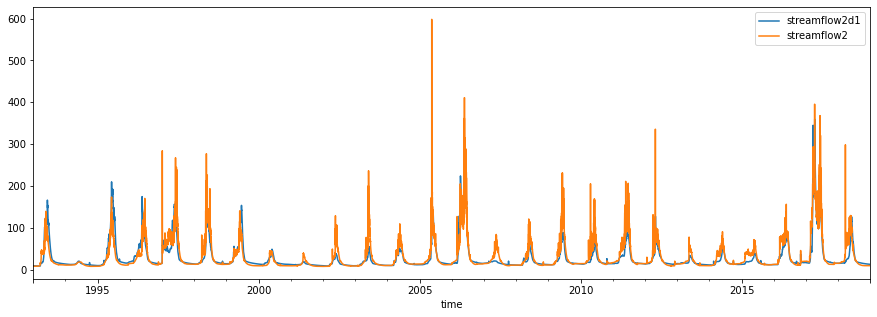

In [10]:
testCombine.plot(x = "time",figsize = (15,5))

<AxesSubplot:xlabel='time'>

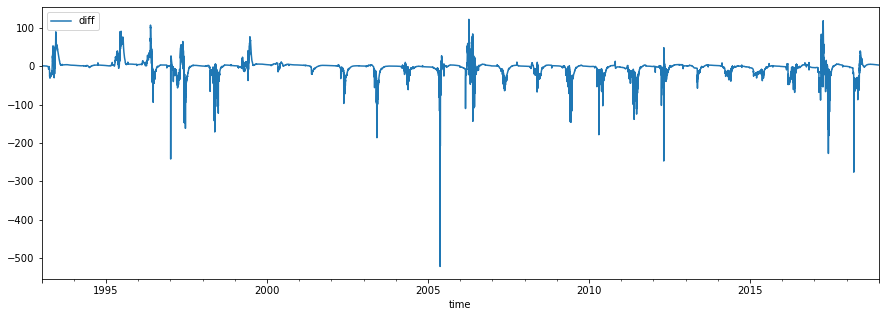

In [11]:
testCombine["diff"] = testCombine["streamflow2d1"] - testCombine["streamflow2"]
testCombine.plot(x = "time",y='diff',figsize = (15,5))

In [13]:
import dataretrieval.nwis as nwis
import datetime as dt

station_id = "13152500" # Malad
act = nwis.get_record(sites=station_id,service = 'iv',start = '1979-01-31', end ='2020-12-31')

In [14]:
nwis = act.drop(['00060_cd','site_no'],axis=1)
nwis['time'] = pd.to_datetime(nwis.index,)
nwis['time'] = nwis['time'].dt.tz_localize(None)
nwis.columns = ["streamflow_nwis","time"]
nwis = nwis.reset_index(drop=True)
nwis['streamflow_nwis'] = nwis['streamflow_nwis'] * cfs_2_cms

In [15]:
testCombine_nwis= pd.merge(testCombine,nwis, on='time',how='inner')
testCombine_nwis = testCombine_nwis.drop(['diff'],axis=1)

<AxesSubplot:xlabel='time'>

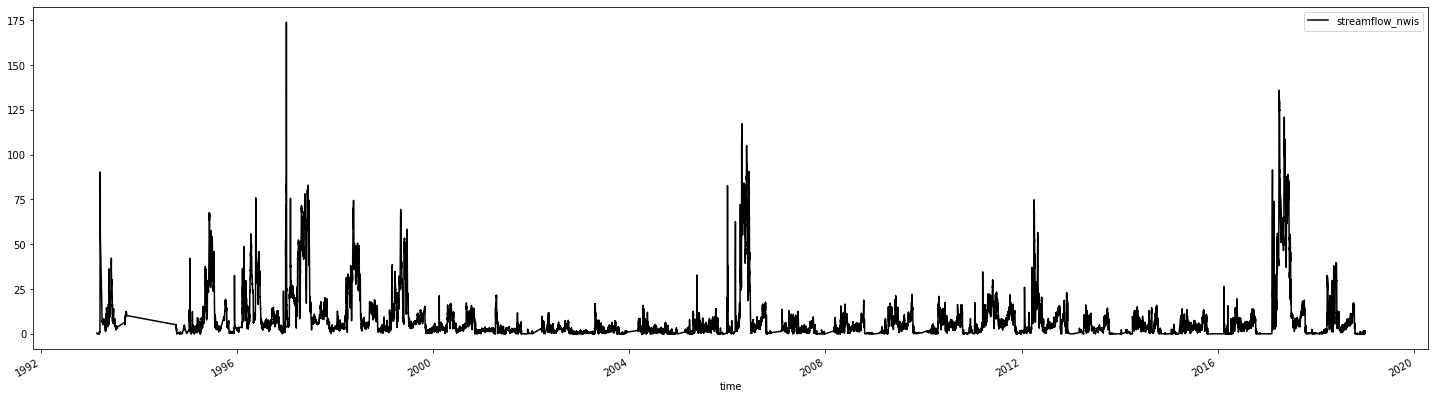

In [16]:
testCombine_nwis.plot(x = "time",y= 'streamflow_nwis',figsize = (25,7),color = 'black')

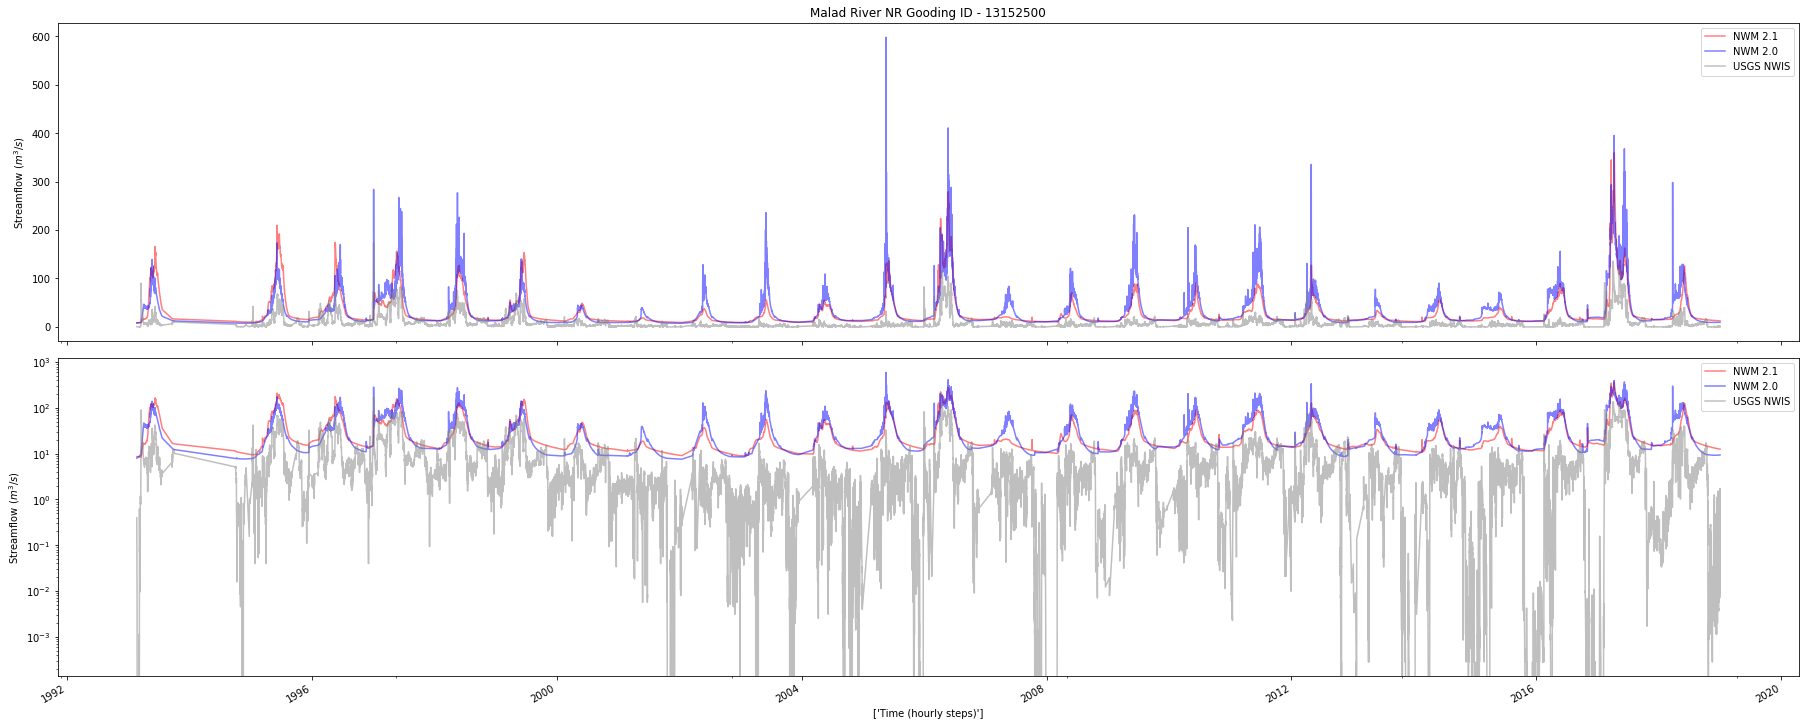

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,sharex=True,figsize=(25, 10),squeeze=True)
testCombine_nwis.plot(x = "time",alpha = 0.5, color = ['red','blue','grey'], ax=ax[0])
ax[0].legend(["NWM 2.1", "NWM 2.0", "USGS NWIS"])
testCombine_nwis.plot(x = "time",alpha = 0.5,logy=True,color = ['red','blue','grey'], ax=ax[1])
ax[1].legend(["NWM 2.1", "NWM 2.0", "USGS NWIS"],loc = "upper right")
ax[0].set_title("Malad River NR Gooding ID - 13152500")
ax[0].set_ylabel('Streamflow ($m^3/s$)')
ax[1].set_ylabel('Streamflow ($m^3/s$)')
ax[1].set_xlabel(['Time (hourly steps)'])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

fig.savefig("../docs/MALADtest.png", dpi=600)

In [34]:
testCombine_nwis["diff2"] = testCombine_nwis["streamflow2"]- testCombine_nwis["streamflow_nwis"] 
testCombine_nwis["diff2d1"] = testCombine_nwis["streamflow_nwis"] - testCombine_nwis["streamflow2d1"]

In [ ]:
testCombine_nwis.plot(x = "time",y='diff2',figsize = (15,5),color='blue')

In [ ]:
testCombine_nwis.plot(x = "time",y='diff2d1',figsize = (15,5),color='red')

/opt/miniconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


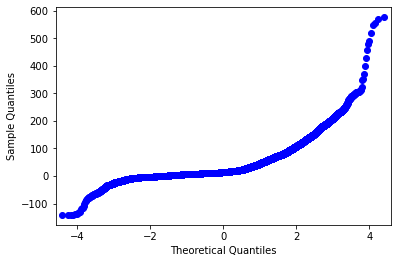

In [36]:
import statsmodels.api as sm
import scipy.stats

#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(testCombine_nwis["diff2"])
plt.show()
